In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
import os
import sys
import copy
import argparse
import random

import torch
import torch.nn as nn

from joblib import Parallel, delayed

import src.RL.utils as utils
import src.RL.TD3 as TD3
from src.RL.environment import ManhattanTrafficEnv
from src.simulator.config import *

Using CUDA device
[INFO] Route functions are ready. 


In [2]:
# Check Device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")

Using CUDA device


In [3]:
class FixedNormalizer(object):
    def __init__(self):
        if MAP_NAME == 'Manhattan':
            path = 'mean_std_data_NYC_FULL.npz'
        elif MAP_NAME == 'Utrecht':
            path = 'mean_std_data_Utrecht_FULL.npz'

        print(f"Loading mean and std for map {MAP_NAME} from {path}")
            
        assert os.path.exists(path), "mean_std_data not found"
        data = np.load(path)
        self.mean = torch.tensor(data['mean'], dtype=torch.float32).to(device)
        self.std = torch.tensor(data['std'], dtype=torch.float32).to(device)
        self.std[self.std == 0] = 1.0 # avoid division by zero

    def __call__(self, x):
        # # temp skip
        # return x
        return (x - self.mean) / (self.std)

In [4]:
def toggle_theta_test_non_policy(env, toggle_time, toggle_duration, sim_duration, origin_theta, toggle_theta):
    env.simulator.theta = origin_theta
    for _ in tqdm(range(int(sim_duration/TIME_STEP)),desc='Toggle Theta Test'):
        env.simulator.system_time += TIME_STEP
        if env.simulator.system_time >= toggle_time and env.simulator.system_time < toggle_time + toggle_duration:
            env.simulator.theta = toggle_theta
            if env.simulator.system_time == toggle_time:
                print("Toggle theta to", env.simulator.theta)
        else:
            env.simulator.theta = origin_theta
            if env.simulator.system_time == toggle_time + toggle_duration:
                print("Toggle theta back to", env.simulator.theta)
        env.simulator.run_cycle()
        
    rejection_rates = env.simulator.past_rejections
    anticipatory_costs = env.simulator.past_costs
    idle_veh_num_list = env.simulator.idle_veh_num_list
    users_costs = env.simulator.past_users_costs
    operators_costs = env.simulator.past_operators_costs
    return rejection_rates, anticipatory_costs, idle_veh_num_list, users_costs, operators_costs

In [5]:
def warm_up(env, duration):
    for _ in tqdm(range(int(duration/TIME_STEP)), desc=f"Warm-Up"):
        env.simulator.system_time += TIME_STEP
        env.simulator.run_cycle()
    return env

In [6]:
def policy_run(env, policy, sim_duration, fixed_normalizer):
    state, reward, done, _  = env.step(action = 0.0)
    state = fixed_normalizer(state)
    edge_index = env.graph_to_data(env.simulator.get_simulator_network_by_areas())
    # auto_encoder = policy.gnn_auto_encoder.to(device)
    gnn_encoder = policy.gnn_encoder.to(device)
    # encoded_state, decoded_state, _ = auto_encoder(state, edge_index, 1)
    rej_rate = np.mean(env.simulator.current_cycle_rej_rate)
    state_theta = env.simulator.theta/MAX_THETA # normalize theta
    encoded_state = gnn_encoder(state, edge_index, 1, rej_rate, state_theta)

    for _ in tqdm(range(int(sim_duration/(TIME_STEP*5))), desc="Policy Run"):
        action = policy.select_action(encoded_state)
        next_state, reward, done, _ = env.step(action)
        rej_rate = np.mean(env.simulator.current_cycle_rej_rate)
        state_theta = env.simulator.theta/MAX_THETA # normalize theta
        next_state = fixed_normalizer(next_state)
        # next_encoded_state, _, _ = auto_encoder(next_state, edge_index, 1)
        next_encoded_state = gnn_encoder(next_state, edge_index, 1, rej_rate, state_theta)
        encoded_state = next_encoded_state

    rejection_rates = agg_steps_to_state(env.simulator.past_rejections) #length in states(5steps)
    anticipatory_costs = agg_steps_to_state(env.simulator.past_costs)
    idle_veh_num_list = agg_steps_to_state(env.simulator.idle_veh_num_list)
    users_costs = agg_steps_to_state(env.simulator.past_users_costs)
    operators_costs = agg_steps_to_state(env.simulator.past_operators_costs)
    theta_list = agg_steps_to_state(env.simulator.past_thetas)
    
    return rejection_rates, anticipatory_costs, operators_costs, users_costs, idle_veh_num_list, theta_list

def non_policy_run(env, sim_duration, initial_theta):
    env.simulator.theta = initial_theta

    for _ in tqdm(range(int(sim_duration/TIME_STEP)), desc='Non-Policy Run'):
        env.simulator.system_time += TIME_STEP
        env.simulator.run_cycle()
        
    rejection_rates = agg_steps_to_state(env.simulator.past_rejections)
    anticipatory_costs = agg_steps_to_state(env.simulator.past_costs)
    idle_veh_num_list = agg_steps_to_state(env.simulator.idle_veh_num_list)
    users_costs = agg_steps_to_state(env.simulator.past_users_costs)
    operators_costs = agg_steps_to_state(env.simulator.past_operators_costs)
    return rejection_rates, anticipatory_costs, operators_costs, users_costs, idle_veh_num_list

def agg_steps_to_state(input_list):
    # get mean of every 5 steps
    state_list = []
    for i in range(0, len(input_list), 5):
        state_list.append(np.mean(input_list[i:i+5]))
    return state_list


In [7]:
def toggle_theta_test(env, sim_duration, fixed_normalizer, toggle_theta, toggle_time, toggle_duration):
    state, reward, done, _  = env.step(action = -1)
    state = fixed_normalizer(state)


    for _ in tqdm(range(int(sim_duration/(TIME_STEP*5))), desc=f"Toggle Theta Test"):
        # print(env.simulator.theta)
        if env.simulator.system_time >= toggle_time and env.simulator.system_time < toggle_time + toggle_duration:
            action = toggle_theta
        else:
            action = -1
        next_state, reward, done, _ = env.step(action)
        if env.simulator.system_time == toggle_time + TIME_STEP*5 or env.simulator.system_time == toggle_time + toggle_duration + TIME_STEP*5:
            print(f"toggled theta: {env.simulator.theta}")
        
    rejection_rates = env.past_rejections
    anticipatory_costs = env.past_anticipatory_costs
    idle_veh_num_list = env.simulator.idle_veh_num_list
    return rejection_rates, anticipatory_costs, idle_veh_num_list

In [8]:
def plot_both_multi_toggle(data_1, data_2, sim_duration, warm_up_duration, toggle_periods_1, toggle_periods_2, type, n=12):
    time_scope = sim_duration + warm_up_duration
    if type == 'Reward':
        time_scope -= (int(MEMORY_SIZE)*TIME_STEP*5)
    elif type == 'Theta':
        time_scope = len(data_1)*5*TIME_STEP

    time_series = np.arange(0, time_scope, 15 * 5 * n)

    data_1_avg = [np.mean(data_1[i:i + n]) for i in range(0, len(data_1), n)]
    data_2_avg = [np.mean(data_2[i:i + n]) for i in range(0, len(data_2), n)]        

    def create_plot(data_1, data_2, color_1, color_2, label_1, label_2, title, toggle_periods):
        plt.figure(figsize=(12, 6))
        plt.plot(time_series, data_1, color=color_1, label=label_1)
        plt.plot(time_series, data_2, color=color_2, label=label_2)
        plt.xlabel('Time (s)')
        plt.ylabel(type)
        plt.title(title)
        plt.grid(True)
        if toggle_periods:  # Only add toggle period markers if there are any
            for period in toggle_periods:
                plt.axvline(x=period['start'], color='black', linestyle='--')
                plt.axvline(x=period['end'], color='black', linestyle='--')
                plt.axvspan(period['start'], period['end'], color='gray', alpha=0.3)
                plt.text(period['start'], plt.ylim()[0], f"{period['start']}s, θ={period['theta']}", ha='right', va='bottom', rotation=90)
                plt.text(period['end'], plt.ylim()[0], f"{period['end']}s", ha='left', va='bottom', rotation=90)
        
        plt.legend()
        save_name = f'{title}_theta_' + '_'.join([f"{period['theta']}" for period in toggle_periods]) if toggle_periods else f'{title}_no_toggle'
        plt.savefig(f'pics/{save_name}.png', dpi=300, bbox_inches='tight')
        plt.show()

    create_plot(data_1_avg, data_2_avg, 'blue', 'red', 'Base', 'Policy', f'{type}', toggle_periods_2)
    # create_plot(data_1_avg, data_2_avg, 'blue', 'red', 'Base', 'Fixed', f'{type}', toggle_periods_2)

def plot_all_results_both(results, sim_duration, warm_up_duration, toggle_periods_list, n=12):
    if not toggle_periods_list:
        # If there are no toggle periods, just plot the results without comparisons
        metrics = ['Rejection Rate', 'Total Costs', "Operator's Costs", "User's Costs", 'Idle Vehicle Number', 'Reward', 'Theta']
        for i, metric in enumerate(metrics):
            plot_both_multi_toggle(
                results[0][i],
                results[1][i], 
                sim_duration,
                warm_up_duration,
                None,
                None,
                metric,
                n
            )
    else:
        base_toggle_periods = toggle_periods_list[0]
        toggle_periods_list = toggle_periods_list[1:]
        base_result = results[0]
        compare_results = results[1:]
        metrics = ['Rejection Rate', 'Total Costs', "Operator's Costs", "User's Costs", 'Idle Vehicle Number', 'Reward']

        for i, metric in enumerate(metrics):
            for j, toggle_periods in enumerate(toggle_periods_list):
                plot_both_multi_toggle(
                    base_result[i],
                    compare_results[j][i],
                    sim_duration,
                    warm_up_duration,
                    base_toggle_periods,
                    toggle_periods,
                    metric,
                    n
                )

In [9]:
def run_fixed_theta(initial_theta, sim_duration, warm_up_duration):
    test_env = ManhattanTrafficEnv()
    test_env.uniform_reset()
    test_env.simulator.theta = initial_theta
    env = warm_up(test_env, warm_up_duration)
    return non_policy_run(env, sim_duration, initial_theta)

def run_policy_theta(initial_theta, sim_duration, warm_up_duration, policy):
    test_env = ManhattanTrafficEnv()
    fixed_normalizer = FixedNormalizer()
    
    test_env.uniform_reset()
    test_env.simulator.theta = initial_theta
    env = warm_up(test_env, warm_up_duration)
    # edge_index = test_env.graph_to_data(test_env.simulator.get_simulator_network_by_areas())
    
    return policy_run(env, policy, sim_duration, fixed_normalizer)

def decay_reward(reward_list):
    reward = 0
    for i in range(MEMORY_SIZE):
        reward += reward_list[i] * np.exp(-0.01 * i)
    reward /= MEMORY_SIZE
    return reward

def immediate_reward(rejection_rate, users_cost):
    recent_rej = rejection_rate
    mean_rej = np.mean(recent_rej)
    reward_rej = (REJ_THRESHOLD_REWARD - mean_rej) * REJ_THRESHOLD_MULTIPLIER
    reward_cost = (BASE_USER_COST - users_cost) * COST_REWARD_MULTIPLIER
    reward = reward_rej + reward_cost + REWARD_OFFSET

    return reward

def delayed_reward(input_reward_list):
    delayed_reward_list = []
    reward_list = copy.deepcopy(input_reward_list)
    for i in range(len(reward_list)-MEMORY_SIZE):
        reward = 0
        # 计算权重
        weights = [1 - weight_idx/MEMORY_SIZE for weight_idx in range(MEMORY_SIZE)]
        # 计算归一化因子
        normalizer = sum(weights)
        # 标准化权重使其和为1
        # normalized_weights = [w/normalizer for w in range(MEMORY_SIZE)]
        normalized_weights = [w/normalizer for w in weights]
        
        # 使用标准化后的权重计算reward
        for j in range(MEMORY_SIZE):
            reward += reward_list[i+j] * normalized_weights[j]
        
        # scaled_reward = reward * REWARD_MULTIPLIER 
        scaled_reward = reward / MAX_REWARD

        delayed_reward = scaled_reward
        delayed_reward = np.clip(scaled_reward, -1.0, 1.0)
        delayed_reward_list.append(delayed_reward)
    print(len(delayed_reward_list))
    # return reward #should be scaled_reward
    return delayed_reward_list

def calculate_rewards(rejection_rates, users_costs):
    current_rewards_list = []
    for rejection_rate, users_cost in zip(rejection_rates, users_costs):
        current_reward = immediate_reward(rejection_rate, users_cost)
        current_rewards_list.append(current_reward)
    # print(len(current_rewards_list))
    
    current_decay_reward_list = []
    while len(current_rewards_list) > MEMORY_SIZE:
        current_decay_reward = decay_reward(current_rewards_list)
        current_decay_reward_list.append(current_decay_reward)
        current_rewards_list.pop(0)
    # print(len(current_decay_reward_list))
    return current_decay_reward_list

def calculate_delayed_rewards(input_rejection_rates, input_users_costs):
    current_rewards_list = []
    rejection_rates = copy.deepcopy(input_rejection_rates)
    users_costs = copy.deepcopy(input_users_costs)
    
    for i in range(len(rejection_rates)):
        rejection_rate = np.mean(rejection_rates[i:i+PAST_REJ_NUM]) # mean of first some steps
        current_reward = immediate_reward(rejection_rate, users_costs[i])
        current_rewards_list.append(current_reward)

    # for rejection_rate, users_cost in zip(rejection_rates, users_costs):
    #     rejection_rate = rejection_rates[-PAST_REJ_NUM:]
    #     current_reward = immediate_reward(rejection_rate, users_cost)
    #     current_rewards_list.append(current_reward)
    #     rejection_rates.pop(0)

    delayed_reward_list = delayed_reward(current_rewards_list)
    return delayed_reward_list

def prune_results(results, sim_duration, warm_up_duration, initial_theta):
    # compare two results. prune the longer one
    base_result = results[0]
    policy_result = results[1]
    for i in range(len(base_result)):
        if len(base_result[i]) > len(policy_result[i]):
            base_result[i] = base_result[i][:len(policy_result[i])]
        else:
            policy_result[i] = policy_result[i][:len(base_result[i])]
    # add theta list to base result
    fixed_theta_list = [initial_theta] * len(policy_result[-1])
    base_result.append(fixed_theta_list)
    return [base_result, policy_result]

def check_result_length(results):
    for i in range(len(results)):
        for j in range(len(results[i])):
            print(len(results[i][j]))


In [10]:
def plot_comparison_multi_toggle(data_1, data_2, sim_duration, warm_up_duration, toggle_periods_1, toggle_periods_2, type, n=12):
    time_scope = sim_duration + warm_up_duration
    if type == 'Reward':
        time_scope -= int(MEMORY_SIZE)*TIME_STEP
        n=1
    time_series = np.arange(0, time_scope, 15 * n)

    data_1_avg = [np.mean(data_1[i:i + n]) for i in range(0, len(data_1), n)]
    data_2_avg = [np.mean(data_2[i:i + n]) for i in range(0, len(data_2), n)]        
    diff_data_avg = [d2 - d1 for d2, d1 in zip(data_2_avg, data_1_avg)]

    def create_plot(data, color, label, title, toggle_periods):
        plt.figure(figsize=(12, 6))
        plt.plot(time_series, data, color=color)
        plt.xlabel('Time (s)')
        plt.ylabel(type)
        plt.title(title)
        plt.grid(True)
        if toggle_periods:  # Only add toggle period markers if there are any
            for period in toggle_periods:
                plt.axvline(x=period['start'], color='black', linestyle='--')
                plt.axvline(x=period['end'], color='black', linestyle='--')
                plt.axvspan(period['start'], period['end'], color='gray', alpha=0.3)
                plt.text(period['start'], plt.ylim()[0], f"{period['start']}s, θ={period['theta']}", ha='right', va='bottom', rotation=90)
                plt.text(period['end'], plt.ylim()[0], f"{period['end']}s", ha='left', va='bottom', rotation=90)
        
        # plt.legend()
        save_name = f'{title}_theta_' + '_'.join([f"{period['theta']}" for period in toggle_periods]) if toggle_periods else f'{title}_no_toggle'
        plt.savefig(f'pics/{save_name}.png', dpi=300, bbox_inches='tight')
        plt.show()

    create_plot(diff_data_avg, 'green', f'Difference in {type} (Policy - Base)', f'Difference in {type} (Policy - Base)', toggle_periods_2)
    # create_plot(diff_data_avg, 'green', f'Difference in {type} (Toggle - Fixed)', f'Difference in {type} (Toggle - Fixed)', toggle_periods_2)

def plot_all_results_comparison(results, sim_duration, warm_up_duration, toggle_periods_list, n=12):
    if not toggle_periods_list:
        # If there are no toggle periods, just plot the results without comparisons
        metrics = ['Rejection Rate', 'Total Costs', "Operator's Costs", "User's Costs", 'Idle Vehicle Number', 'Reward', 'Theta']
        for i, metric in enumerate(metrics):
            plot_comparison_multi_toggle(
                results[0][i],
                results[1][i], 
                sim_duration,
                warm_up_duration,
                None,
                None,
                metric,
                n
            )
    else:
        base_toggle_periods = toggle_periods_list[0]
        toggle_periods_list = toggle_periods_list[1:]
        base_result = results[0]
        compare_results = results[1:]
        metrics = ['Rejection Rate', 'Total Costs', "Operator's Costs", "User's Costs", 'Idle Vehicle Number', 'Reward', 'Theta']

        for i, metric in enumerate(metrics):
            for j, toggle_periods in enumerate(toggle_periods_list):
                plot_comparison_multi_toggle(
                    base_result[i],
                    compare_results[j][i],
                    sim_duration,
                    warm_up_duration,
                    base_toggle_periods,
                    toggle_periods,
                    metric,
                    n
                )

In [11]:
def run_test_multi_toggle(toggle_periods, initial_theta, sim_duration, warm_up_duration):
    test_env = ManhattanTrafficEnv()
    test_env.uniform_reset()
    test_env.simulator.theta = initial_theta
    env = warm_up(test_env, warm_up_duration)
    return toggle_theta_test_non_policy_multi_periods(env, toggle_periods, sim_duration, initial_theta)

def toggle_theta_test_non_policy_multi_periods(env, toggle_periods, sim_duration, initial_theta):
    env.simulator.theta = initial_theta

    for _ in tqdm(range(int(sim_duration/TIME_STEP)), desc='Multi-Toggle Theta Test'):
        env.simulator.system_time += TIME_STEP
        current_theta = initial_theta

        for period in toggle_periods:
            if period['start'] <= env.simulator.system_time < period['end']:
                current_theta = period['theta']
                break

        env.simulator.theta = current_theta
        env.simulator.run_cycle()
        
    rejection_rates = env.simulator.past_rejections
    anticipatory_costs = env.simulator.past_costs
    idle_veh_num_list = env.simulator.idle_veh_num_list
    users_costs = env.simulator.past_users_costs
    operators_costs = env.simulator.past_operators_costs

    return [rejection_rates, anticipatory_costs, operators_costs, users_costs, idle_veh_num_list]


In [ ]:
# Main TEST CASE
sim_duration = 3600 * 1.5  # 7 hours
warm_up_duration = 3600 * 0 # 1 hour
theta_duration = 1800 # 30 mins 
initial_theta = 30.0


toggle_periods_1 = [
    # all time zero theta
    {'start': 0, 'end': sim_duration, 'theta': 30.0},
]
toggle_periods_2 = [
    {'start': warm_up_duration + 0, 'end': warm_up_duration + 0 + theta_duration, 'theta': 15.0},
    {'start': warm_up_duration + 7200, 'end': warm_up_duration + 7200 + theta_duration, 'theta': 30.0},
    {'start': warm_up_duration + 14400, 'end': warm_up_duration + 14400 + theta_duration, 'theta': 45.0},
    {'start': warm_up_duration + 21600, 'end': warm_up_duration + 21600 + theta_duration, 'theta': 60.0},
]

toggle_periods_3 = [
    {'start': warm_up_duration + 0, 'end': warm_up_duration + 0 + theta_duration, 'theta': 15.0},
    # {'start': warm_up_duration + 7200, 'end': warm_up_duration + 7200 + theta_duration, 'theta': 30.0},
    {'start': warm_up_duration + 14400, 'end': warm_up_duration + 14400 + theta_duration, 'theta': 45.0},
    # {'start': warm_up_duration + 21600, 'end': warm_up_duration + 21600 + theta_duration, 'theta': 60.0},
]

toggle_periods_4 = [
    {'start': warm_up_duration + 0, 'end': warm_up_duration + 0 + theta_duration, 'theta': 15.0},
    # {'start': warm_up_duration + 7200, 'end': warm_up_duration + 7200 + theta_duration, 'theta': 30.0},
    # {'start': warm_up_duration + 14400, 'end': warm_up_duration + 14400 + theta_duration, 'theta': 45.0},
    {'start': warm_up_duration + 21600, 'end': warm_up_duration + 21600 + theta_duration, 'theta': 60.0},
]

toggle_periods_5 = [
    {'start' : warm_up_duration + 0, 'end' : warm_up_duration + 600, 'theta' : 0.0},
    {'start' : warm_up_duration + 1000, 'end' : warm_up_duration + 1600, 'theta' : 15.0},
    {'start' : warm_up_duration + 2000, 'end' : warm_up_duration + 2600, 'theta' : 30.0},
    {'start' : warm_up_duration + 3000, 'end' : warm_up_duration + 3600, 'theta' : 45.0},
    {'start' : warm_up_duration + 4000, 'end' : warm_up_duration + 4600, 'theta' : 60.0},
]
# toggle_periods_list = [toggle_periods_1, toggle_periods_2, toggle_periods_3, toggle_periods_4]
toggle_periods_list = [toggle_periods_1, toggle_periods_5]

# Using joblib's Parallel with loky backend
# results = Parallel(n_jobs=2)(
#     delayed(run_test_multi_toggle)(tp, initial_theta, sim_duration, warm_up_duration) for tp in toggle_periods_list)

fixed_results = run_test_multi_toggle(toggle_periods_1, initial_theta, sim_duration, warm_up_duration)
toggle_results = run_test_multi_toggle(toggle_periods_5, initial_theta, sim_duration, warm_up_duration)

# fixed_decay_rewards = calculate_rewards(fixed_results[0], fixed_results[3])
# toggle_decay_rewards = calculate_rewards(toggle_results[0], toggle_results[3])

fixed_delayed_rewards = calculate_delayed_rewards(fixed_results[0], fixed_results[3])
toggle_delayed_rewards = calculate_delayed_rewards(toggle_results[0], toggle_results[3])

fixed_results.append(fixed_delayed_rewards)
toggle_results.append(toggle_delayed_rewards)

results = [fixed_results, toggle_results]
# # optimized run test multi toggle
# results = Parallel(n_jobs=2)(delayed(optimized_run_test_multi_toggle)(toggle_periods, initial_theta, sim_duration, warm_up_duration) 
#                              for toggle_periods in [toggle_periods_1, toggle_periods_2])
plot_all_results_both(results, sim_duration, warm_up_duration, toggle_periods_list, n=4)
# plot_all_results_comparison(results, sim_duration, warm_up_duration, toggle_periods_list)

# get mean rej_rate and user cost 
mean_rej_rate = np.mean(fixed_results[0])
mean_user_cost = np.mean(fixed_results[3])

print(f'Mean Rejection Rate: {mean_rej_rate}')
print(f'Mean User Cost: {mean_user_cost}')

In [ ]:
# TEST CASE 1: policy theta vs fixed theta
# Define the args
kwargs = {
    "state_dim": NUM_AREA*NUM_FEATURES,
    "action_dim": 1,
    "max_action": 1.0,
    "discount": 0.95,
    "tau": 0.005,
    "policy_noise": 0.1,
    "noise_clip": 0.15,
    "policy_freq": 2,
}

epoch = 20
model_name = f'TD3_AUTOENCODER_{epoch}'
# epoch = 112
# model_name = f'TD3_AUTOENCODER_HALF_{epoch}'

# Load Policy
policy = TD3.TD3(**kwargs)
if MAP_NAME == 'Manhattan':
    policy.load(f"god_blessed_models/Manhattan_finetune/{model_name}")
elif MAP_NAME == 'Utrecht':
    policy.load(f"god_blessed_models/Utrecht_finetune/{model_name}")

# Define parameters for both runs
theta_method = 'Fixed'
initial_theta = 20.0
sim_duration = 3600 * 7  # 7 hours
warm_up_duration = 3600 * 1  # 1 hour

if sim_duration <= 3600 * 2:
    n = 1
elif sim_duration <= 3600 * 4:
    n = 2
elif sim_duration <= 3600 * 6:
    n = 4
else:
    n = 4

print("Simulation on: ", MAP_NAME)

policy_results = run_policy_theta(initial_theta, sim_duration, warm_up_duration, policy)
fixed_results = run_fixed_theta(initial_theta, sim_duration, warm_up_duration)
FIXED_RESULT_FILE_NAME = 'fixed_simulation_results_normal_8hrs_20theta_' + MAP_NAME + '.pkl'
with open(FIXED_RESULT_FILE_NAME, 'wb') as f:
    pickle.dump(fixed_results, f)


Simulation on:  Manhattan
---------------------------------
[INFO] Platform is initialized.
[INFO] Initial Theta: 14.033810639829658
---------------------------------
[INFO] Loading ManhattanData: Full day14
Loading mean and std for map Manhattan from mean_std_data_NYC_FULL.npz
---------------------------------
[INFO] Platform is initialized.
[INFO] Initial Theta: 27.592725236792706
---------------------------------
[INFO] Loading ManhattanData: Full day11
Uniform reset the environment
---------------------------------
[INFO] Platform is initialized.
[INFO] Initial Theta: 30.0
---------------------------------


c:\ProgramData\anaconda3\envs\amod\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\envs\amod\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[INFO] Loading ManhattanData: Full day10
mean rejnan


Warm-Up:   0%|          | 0/240 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-27


Run SIM: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


Updating REWARD_THETA from 20.0 to 20.0
Reward: 0.04342014727924409
current rejection rate: 0.43573802541544476
current user cost: 4.842355555555556


Policy Run:   0%|          | 1/336 [00:01<09:56,  1.78s/it]

Updating REWARD_THETA from 20.0 to 20.397584475576878
Reward: 0.2216357876449504
current rejection rate: 0.2911174362218006
current user cost: 4.725582222222223


Policy Run:   1%|          | 2/336 [00:03<10:40,  1.92s/it]

Updating REWARD_THETA from 20.397584475576878 to 20.764617882668972
Reward: 0.10771813605809405
current rejection rate: 0.3580412569886254
current user cost: 5.565808888888888


Policy Run:   1%|          | 3/336 [00:08<18:50,  3.40s/it]

Updating REWARD_THETA from 20.764617882668972 to 21.103505454957485
Reward: 0.13080300720216015
current rejection rate: 0.3676964569611628
current user cost: 4.699031111111111


Policy Run:   1%|          | 4/336 [00:10<15:00,  2.71s/it]

Updating REWARD_THETA from 21.103505454957485 to 21.451281756162643
Reward: 0.07769561949811704
current rejection rate: 0.402066835603421
current user cost: 4.995604444444444


Policy Run:   1%|▏         | 5/336 [00:12<13:05,  2.37s/it]

Updating REWARD_THETA from 21.451281756162643 to 21.792558804154396
Reward: 0.14558736609168837
current rejection rate: 0.34308445418285227
current user cost: 5.067782222222222


Policy Run:   2%|▏         | 6/336 [00:14<11:47,  2.14s/it]

Updating REWARD_THETA from 21.792558804154396 to 22.135801129043102
Reward: 0.11651933973354162
current rejection rate: 0.3901211428146413
current user cost: 4.383382222222223


Policy Run:   2%|▏         | 7/336 [00:19<16:54,  3.08s/it]

Updating REWARD_THETA from 22.135801129043102 to 22.495405450463295
Reward: 0.07669796986002297
current rejection rate: 0.3996802843759068
current user cost: 5.092142222222222


Policy Run:   2%|▏         | 8/336 [00:21<15:10,  2.78s/it]

Updating REWARD_THETA from 22.495405450463295 to 22.81376574188471
Reward: 0.1832882301194278
current rejection rate: 0.2865509193449213
current user cost: 5.821266666666666


Policy Run:   3%|▎         | 9/336 [00:24<16:06,  2.96s/it]

Updating REWARD_THETA from 22.81376574188471 to 23.180430717766285
Reward: 0.07645039056826164
current rejection rate: 0.3894423041560783
current user cost: 5.405471111111111


Policy Run:   3%|▎         | 10/336 [00:26<14:53,  2.74s/it]

Updating REWARD_THETA from 23.180430717766285 to 23.558557704091072
Reward: 0.15561584897075276
current rejection rate: 0.3485829406725209
current user cost: 4.652115555555556


Policy Run:   3%|▎         | 11/336 [00:39<31:44,  5.86s/it]

Updating REWARD_THETA from 23.558557704091072 to 23.960988484323025
Reward: 0.1835457206306239
current rejection rate: 0.33507782540040604
current user cost: 4.3590222222222215


Policy Run:   4%|▎         | 12/336 [00:41<25:13,  4.67s/it]

Updating REWARD_THETA from 23.960988484323025 to 24.32431284338236
Reward: 0.17815376724175458
current rejection rate: 0.3506340828540934
current user cost: 4.0271333333333335


Policy Run:   4%|▍         | 13/336 [00:43<20:40,  3.84s/it]

Updating REWARD_THETA from 24.32431284338236 to 24.679734967648983
Reward: 0.28194090852154824
current rejection rate: 0.2502806503061172
current user cost: 4.443057777777778


Policy Run:   4%|▍         | 14/336 [00:45<18:04,  3.37s/it]

Updating REWARD_THETA from 24.679734967648983 to 25.03427218645811
Reward: 0.18267088210180632
current rejection rate: 0.3385693760262726
current user cost: 4.2761466666666665


Policy Run:   4%|▍         | 15/336 [00:57<30:46,  5.75s/it]

Updating REWARD_THETA from 25.03427218645811 to 25.388746820390224
Reward: 0.22561499984459982
current rejection rate: 0.24156468531468533
current user cost: 6.1126844444444455


Policy Run:   5%|▍         | 16/336 [00:59<24:35,  4.61s/it]

Updating REWARD_THETA from 25.388746820390224 to 25.725553892552853
Reward: 0.18970539602925812
current rejection rate: 0.3361314292348775
current user cost: 4.173422222222222


Policy Run:   5%|▌         | 17/336 [01:01<20:24,  3.84s/it]

Updating REWARD_THETA from 25.725553892552853 to 26.09511438757181
Reward: 0.17352822068965523
current rejection rate: 0.35103448275862065
current user cost: 4.13076


Policy Run:   5%|▌         | 18/336 [01:03<17:51,  3.37s/it]

Updating REWARD_THETA from 26.09511438757181 to 26.410459280014038
Reward: 0.2620073185913186
current rejection rate: 0.27895167895167894
current user cost: 4.081266666666667


Policy Run:   6%|▌         | 19/336 [01:13<28:17,  5.35s/it]

Updating REWARD_THETA from 26.410459280014038 to 26.71685403212905
Reward: 0.27082145422792475
current rejection rate: 0.25309382518043305
current user cost: 4.63664888888889


Policy Run:   6%|▌         | 20/336 [01:15<23:06,  4.39s/it]

Updating REWARD_THETA from 26.71685403212905 to 27.013220489025116
Reward: 0.28821005021645024
current rejection rate: 0.26648629148629144
current user cost: 3.8001599999999995


Policy Run:   6%|▋         | 21/336 [01:17<19:38,  3.74s/it]

Updating REWARD_THETA from 27.013220489025116 to 27.3117065243423
Reward: 0.2717763995088685
current rejection rate: 0.26314618559446146
current user cost: 4.311204444444444


Policy Run:   7%|▋         | 22/336 [01:19<16:33,  3.17s/it]

Updating REWARD_THETA from 27.3117065243423 to 27.61148514226079
Reward: 0.24417188504675402
current rejection rate: 0.302716466164742
current user cost: 3.8142088888888894


Policy Run:   7%|▋         | 23/336 [01:34<35:19,  6.77s/it]

Updating REWARD_THETA from 27.61148514226079 to 27.90421700105071
Reward: 0.3094722470418471
current rejection rate: 0.24783549783549783
current user cost: 3.8281288888888887


Policy Run:   7%|▋         | 24/336 [01:36<28:02,  5.39s/it]

Updating REWARD_THETA from 27.90421700105071 to 28.192707244306803
Reward: 0.3084933741890959
current rejection rate: 0.2295284103979756
current user cost: 4.401813333333334


Policy Run:   7%|▋         | 25/336 [01:39<23:30,  4.54s/it]

Updating REWARD_THETA from 28.192707244306803 to 28.472834583371878
Reward: 0.25209722704239274
current rejection rate: 0.25619082931652454
current user cost: 5.011844444444446


Policy Run:   8%|▊         | 26/336 [01:41<19:43,  3.82s/it]

Updating REWARD_THETA from 28.472834583371878 to 28.75390250235796
Reward: 0.2729577528188287
current rejection rate: 0.28570972450282794
current user cost: 3.604764444444444


Policy Run:   8%|▊         | 27/336 [01:56<37:18,  7.25s/it]

Updating REWARD_THETA from 28.75390250235796 to 29.041328746825457
Reward: 0.21406083357413158
current rejection rate: 0.32812693498452006
current user cost: 3.804671111111111


Policy Run:   8%|▊         | 28/336 [01:59<30:02,  5.85s/it]

Updating REWARD_THETA from 29.041328746825457 to 29.328765030950308
Reward: 0.24054696216216215
current rejection rate: 0.2928741241241241
current user cost: 4.200102222222222


Policy Run:   9%|▊         | 29/336 [02:01<23:49,  4.66s/it]

Updating REWARD_THETA from 29.328765030950308 to 29.61235787719488
Reward: 0.29799021636141637
current rejection rate: 0.25043956043956045
current user cost: 4.037057777777777


Policy Run:   9%|▉         | 30/336 [02:03<19:50,  3.89s/it]

Updating REWARD_THETA from 29.61235787719488 to 29.89618731662631
Reward: 0.28652445809822363
current rejection rate: 0.2377996923255544
current user cost: 4.7028977777777765


Policy Run:   9%|▉         | 31/336 [02:23<43:40,  8.59s/it]

Updating REWARD_THETA from 29.89618731662631 to 30.188152249902487
Reward: 0.31421514853801175
current rejection rate: 0.21915789473684208
current user cost: 4.569884444444445


Policy Run:  10%|▉         | 32/336 [02:25<33:49,  6.67s/it]

Updating REWARD_THETA from 30.188152249902487 to 30.46906789764762
Reward: 0.37557820289855076
current rejection rate: 0.1884122383252818
current user cost: 3.9581777777777774


Policy Run:  10%|▉         | 33/336 [02:27<26:44,  5.30s/it]

Updating REWARD_THETA from 30.46906789764762 to 30.759484693408012
Reward: 0.27743376774642986
current rejection rate: 0.26988563798908627
current user cost: 3.9675866666666666


Policy Run:  10%|█         | 34/336 [02:29<21:16,  4.23s/it]

Updating REWARD_THETA from 30.759484693408012 to 31.061974726617336
Reward: 0.3162481069340017
current rejection rate: 0.2653717627401838
current user cost: 3.1326444444444443


Policy Run:  10%|█         | 35/336 [02:54<53:12, 10.61s/it]

Updating REWARD_THETA from 31.061974726617336 to 31.358051635324955
Reward: 0.35387347301587296
current rejection rate: 0.2561904761904762
current user cost: 2.467448888888889


Policy Run:  11%|█         | 36/336 [02:56<39:47,  7.96s/it]

Updating REWARD_THETA from 31.358051635324955 to 31.64651593193412
Reward: 0.42821871746031753
current rejection rate: 0.16952380952380952
current user cost: 3.208817777777778


Policy Run:  11%|█         | 37/336 [02:58<30:46,  6.18s/it]

Updating REWARD_THETA from 31.64651593193412 to 31.926919035613537
Reward: 0.3431183468975469
current rejection rate: 0.22527056277056276
current user cost: 3.663924444444445


Policy Run:  11%|█▏        | 38/336 [03:00<24:50,  5.00s/it]

Updating REWARD_THETA from 31.926919035613537 to 32.21010912209749
Reward: 0.36249923463203454
current rejection rate: 0.19573256373256373
current user cost: 4.065542222222223


Policy Run:  12%|█▏        | 39/336 [03:22<49:15,  9.95s/it]

Updating REWARD_THETA from 32.21010912209749 to 32.50584138557315
Reward: 0.349906112732073
current rejection rate: 0.20403572087142066
current user cost: 4.131275555555556


Policy Run:  12%|█▏        | 40/336 [03:24<37:32,  7.61s/it]

Updating REWARD_THETA from 32.50584138557315 to 32.80281675979495
Reward: 0.3370728634920635
current rejection rate: 0.2216084656084656
current user cost: 3.924924444444444


Policy Run:  12%|█▏        | 41/336 [03:26<29:11,  5.94s/it]

Updating REWARD_THETA from 32.80281675979495 to 33.100400883704424
Reward: 0.39200741988304094
current rejection rate: 0.1783859649122807
current user cost: 3.8482355555555556


Policy Run:  12%|█▎        | 42/336 [03:28<23:25,  4.78s/it]

Updating REWARD_THETA from 33.100400883704424 to 33.38951479643583
Reward: 0.37985313762838463
current rejection rate: 0.19281512605042017
current user cost: 3.7192177777777777


360
361


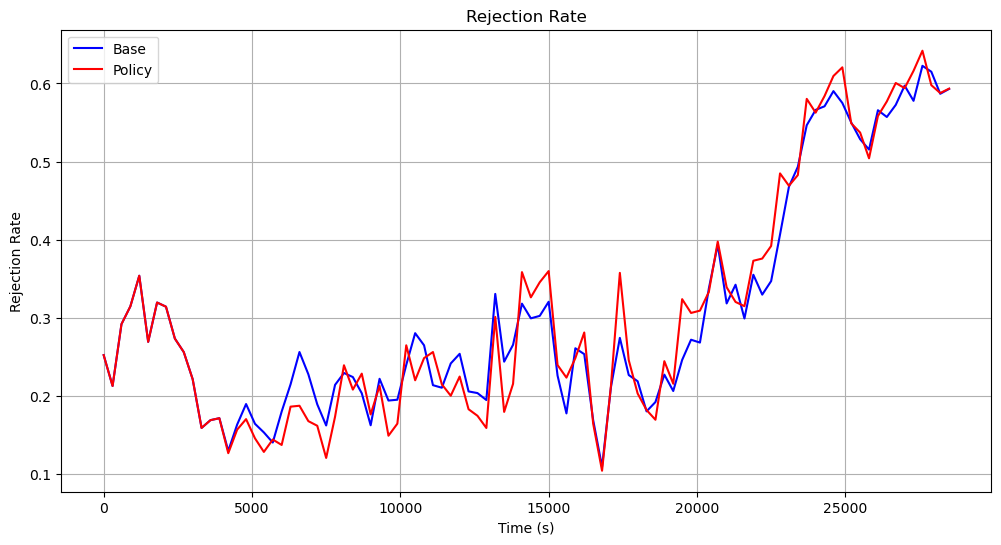

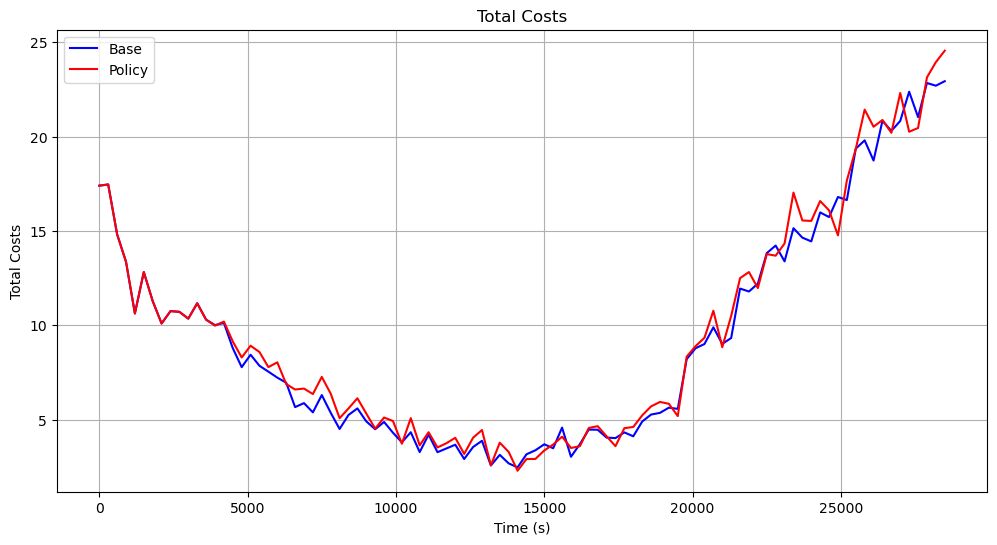

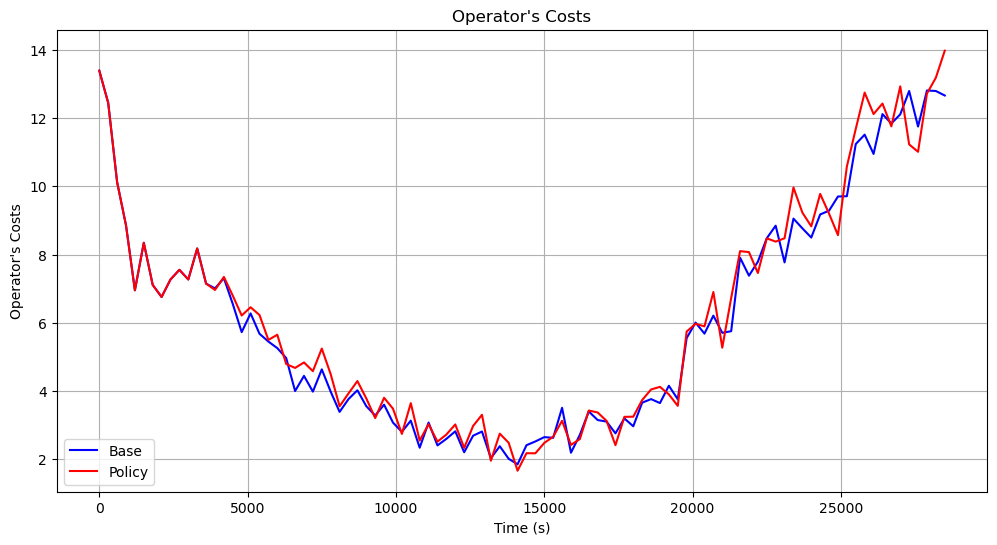

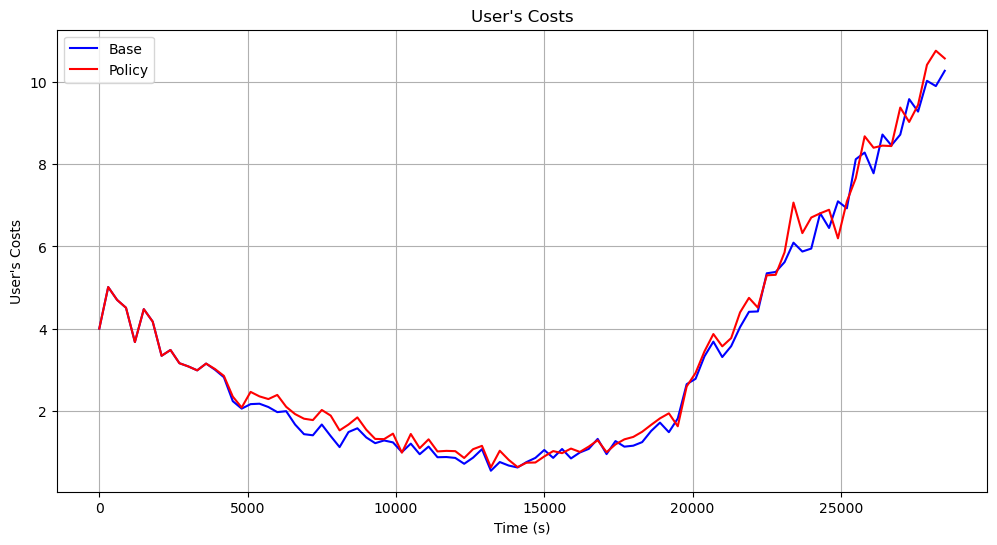

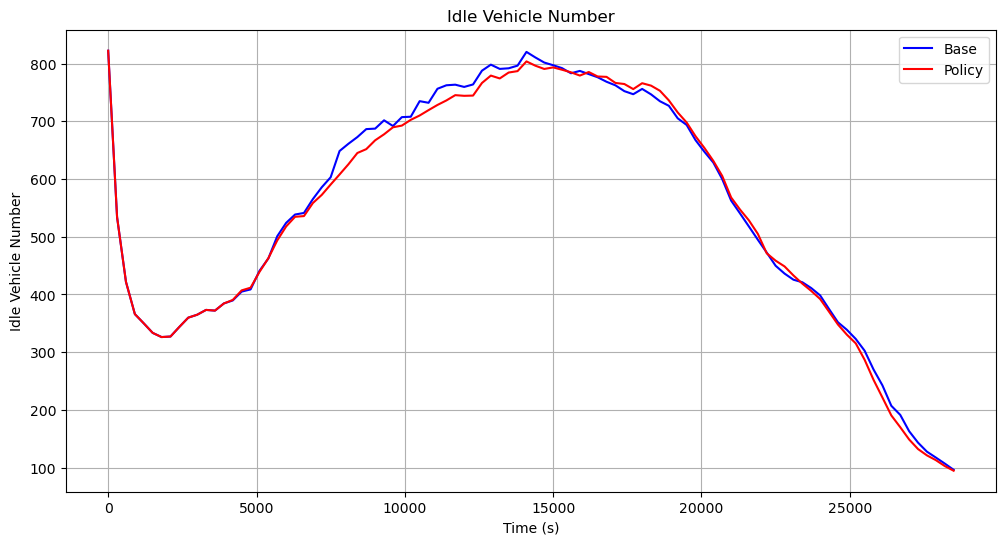

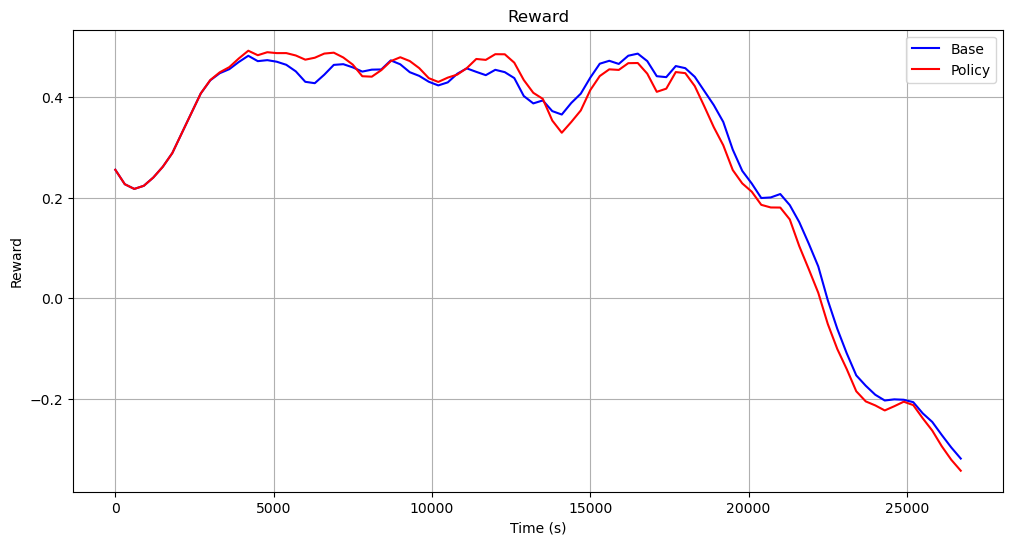

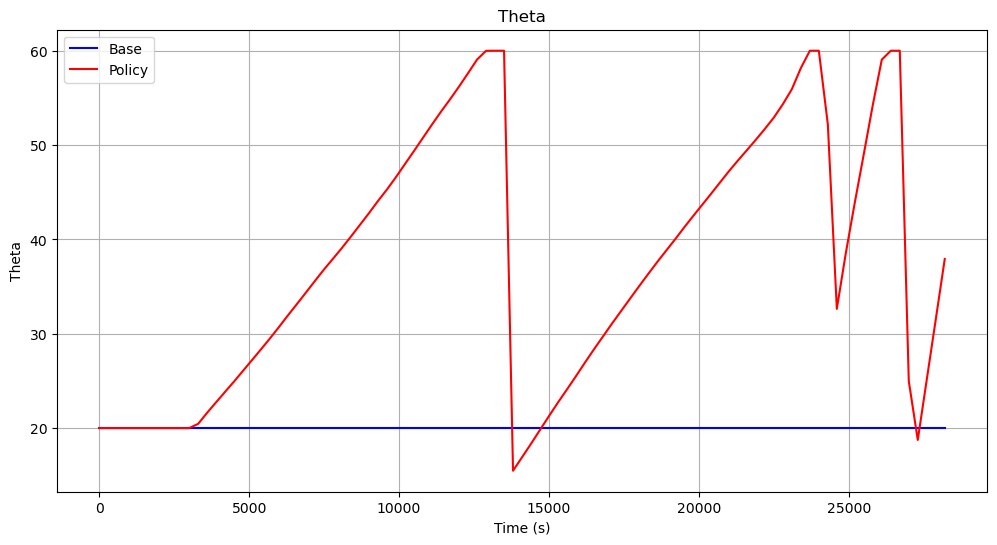

Statistics:
Integral of Rejection Rate:
Fixed: 117.36047219939026
Policy: 118.29329508642351
Integral of User Costs:
Fixed: 1254.1493377777779
Policy: 1319.7643511111112
Integral of Reward:
Fixed: 104.5082554602732
Policy: 101.820728330959


In [15]:
FIXED_RESULT_FILE_NAME = 'fixed_simulation_results_normal_8hrs_20theta_' + MAP_NAME + '.pkl'
with(open(FIXED_RESULT_FILE_NAME, 'rb')) as f:
    fixed_results = pickle.load(f)
results = [fixed_results, policy_results]

# # Unpack results
fixed_rejection_rates, fixed_anticipatory_costs, fixed_operators_costs, fixed_users_costs, fixed_idle_veh_num_list = results[0]
policy_rejection_rates, policy_anticipatory_costs, policy_operators_costs, policy_users_costs, policy_idle_veh_num_list, policy_theta_list = results[1]

fixed_delayed_rewards = calculate_delayed_rewards(fixed_rejection_rates, fixed_users_costs)
policy_delayed_rewards = calculate_delayed_rewards(policy_rejection_rates, policy_users_costs)

#pack all results
results_0 = [fixed_rejection_rates, fixed_anticipatory_costs, fixed_operators_costs, fixed_users_costs, fixed_idle_veh_num_list, fixed_delayed_rewards]
results_1 = [policy_rejection_rates, policy_anticipatory_costs, policy_operators_costs, policy_users_costs, policy_idle_veh_num_list, policy_delayed_rewards, policy_theta_list[5:]]
results = [results_0, results_1]

results = prune_results(results, sim_duration, warm_up_duration, initial_theta)

plot_all_results_both(results, sim_duration, warm_up_duration, [], 4)
# plot_all_results_comparison(results, sim_duration, warm_up_duration, [], n)

print("Statistics:")
print("Integral of Rejection Rate:")
print("Fixed:", np.sum(fixed_rejection_rates))
print("Policy:", np.sum(policy_rejection_rates))
print("Integral of User Costs:")
print("Fixed:", np.sum(fixed_users_costs))
print("Policy:", np.sum(policy_users_costs))
print("Integral of Reward:")
print("Fixed:", np.sum(fixed_delayed_rewards))
print("Policy:", np.sum(policy_delayed_rewards))

In [ ]:
#Manhattan Map
import scipy.io as scipy
import os.path as osp
BASEDIR = os.getcwd()
FOLDER = 'NYC'
MAP_NAME = 'NYC_Manhattan_Map.mat'
REQ_NAME = 'Requests.mat'
OUTPUT_NAME = 'Manhattan_Map' 
map = scipy.loadmat(osp.join(BASEDIR, FOLDER, MAP_NAME))

map_Arcs = pd.DataFrame(map['Arcs']) #ArcsID, Node_Origin, Node_destination, starts from 1 
map_CityArcs = pd.DataFrame(map['CityArcs']) #NodeID, NodeID, starting from 1, 1 means connected.
map_EdgeTimes = pd.DataFrame(map['EdgeTimes']) #ArcTime in seconds, position is ArcID
map_Nodes = pd.DataFrame(map['Nodes']) # Node ID, latitude, longtitude
map_dijkstra_A = pd.DataFrame(map['dijkstra_A']) #Unclear
map_dijkstra_V = pd.DataFrame(map['dijkstra_V']).T #shortest time matrix, transpose it to align with others (Oid, Did)

# Make the index start from 1
map_CityArcs.index = map_CityArcs.index + 1
map_CityArcs.columns = map_CityArcs.columns + 1
map_dijkstra_V.index = map_dijkstra_V.index + 1
map_dijkstra_V.columns = map_dijkstra_V.columns + 1
map_Arcs.rename(columns={0:'ArcID',1:'Oid',2:'Did'},inplace=True)
map_EdgeTimes.rename(columns={0:'ArcTime'},inplace=True)
map_Nodes.rename(columns={0:'NodeID',1:'Latitude',2:'Longitude'},inplace=True)
map_Nodes['NodeID'] = map_Nodes['NodeID'].astype(int)
map_Nodes.loc[map_Nodes['NodeID'] == 3019, 'Longitude'] = -73.950005


In [ ]:
def run_policy_get_stats(initial_theta, sim_duration, warm_up_duration, policy):
    test_env = ManhattanTrafficEnv()
    fixed_normalizer = FixedNormalizer()
    test_env.uniform_reset()
    test_env.simulator.theta = initial_theta
    env = warm_up(test_env, warm_up_duration)
    # edge_index = test_env.graph_to_data(test_env.simulator.get_simulator_network_by_areas())
    
    return policy_run_get_stats(env, policy, sim_duration, fixed_normalizer)

def policy_run_get_stats(env, policy, sim_duration, fixed_normalizer):
    state, reward, done, _  = env.step(action = 0.0)
    state = fixed_normalizer(state)
    edge_index = env.graph_to_data(env.simulator.get_simulator_network_by_areas())
    auto_encoder = policy.gnn_auto_encoder.to(device)
    encoded_state, decoded_state, _ = auto_encoder(state, edge_index, 1)

    for _ in tqdm(range(int(sim_duration/(TIME_STEP*5))), desc="Policy Run"):
        action = policy.select_action(encoded_state)
        next_state, reward, done, _ = env.step(action)
        next_state = fixed_normalizer(next_state)
        next_encoded_state, _, _ = auto_encoder(next_state, edge_index, 1)
        encoded_state = next_encoded_state

    statistics = env.simulator.statistics
    return statistics

def run_fixed_get_stats(initial_theta, sim_duration, warm_up_duration):
    test_env = ManhattanTrafficEnv()
    fixed_normalizer = FixedNormalizer()
    test_env.uniform_reset()
    test_env.simulator.theta = initial_theta
    env = warm_up(test_env, warm_up_duration)

    env.simulator.theta = initial_theta

    for _ in tqdm(range(int(sim_duration/TIME_STEP)), desc='Non-Policy Run'):
        env.simulator.system_time += TIME_STEP
        env.simulator.run_cycle()

    statistic = env.simulator.statistic
    return statistic

In [ ]:
import folium
import cv2
import numpy as np
import pickle
import os.path as osp
from PIL import Image

def lat_lon_to_pixel(latitude, longitude, min_lat, max_lat, min_lon, max_lon, video_resolution=(1080, 1920)):
    # Normalize latitude and longitude to fit within the resolution
    lat_range = max_lat - min_lat
    lon_range = max_lon - min_lon

    # Map to pixel coordinates
    x = int((longitude - min_lon) / lon_range * video_resolution[0])
    y = int((max_lat - latitude) / lat_range * video_resolution[1])  # Invert y-axis for image coordinates

    return (x, y)

def interpolate_position(vehicle_coordinates, scale_factor):
        interpolated_coordinates = []
        for frame in vehicle_coordinates:
            interpolated_coordinates.append(frame)
            next_frame = vehicle_coordinates[vehicle_coordinates.index(frame) + 1]
            for i in range(1, scale_factor):
                interpolated_frame = []
                for j in range(len(frame)):
                    interpolated_frame.append((int(frame[j][0] + (next_frame[j][0] - frame[j][0]) * i / scale_factor), int(frame[j][1] + (next_frame[j][1] - frame[j][1]) * i / scale_factor)))
                interpolated_coordinates.append(interpolated_frame)
        return interpolated_coordinates

def create_transparent_video_frames(stats, map_Nodes, output_folder="frames", video_resolution=(1920, 1080), vehicle_size=5):
    """
    生成带透明背景的 PNG 图像序列。

    参数:
    - vehicle_positions: 每一帧的车辆节点ID列表
    - map_Nodes: 节点信息 DataFrame，必须包含 'Latitude' 和 'Longitude' 列
    - min_lat, max_lat, min_lon, max_lon: 地图的最小和最大经纬度
    - output_folder: 保存 PNG 图像的文件夹
    - video_resolution: 视频分辨率，以 (width, height) 形式表示
    - vehicle_size: 车辆点的大小（像素）
    """
    os.makedirs(output_folder, exist_ok=True)  # 创建输出文件夹

    min_lat = map_Nodes['Latitude'].min()
    max_lat = map_Nodes['Latitude'].max()
    min_lon = map_Nodes['Longitude'].min()
    max_lon = map_Nodes['Longitude'].max()

    vehicle_positions = stats.all_veh_position_series
    for frame_idx, frame in enumerate(vehicle_positions):
        # 创建透明背景的图像
        frame_image = np.zeros((video_resolution[1], video_resolution[0], 4), dtype=np.uint8)  # 使用4通道（RGBA）表示透明背景
        frame_image[:, :, 3] = 0  # 将背景的 Alpha 通道设为 0（完全透明）

        # 绘制每个车辆的位置
        for veh_node_id in frame:
            node = map_Nodes[map_Nodes['NodeID'] == veh_node_id]
            if not node.empty:
                latitude = node.iloc[0]['Latitude']
                longitude = node.iloc[0]['Longitude']
                veh_coordinate = lat_lon_to_pixel(latitude, longitude, min_lat, max_lat, min_lon, max_lon, video_resolution)
                
                # 绘制车辆位置，颜色为蓝色，Alpha 通道为 255（不透明）
                cv2.circle(frame_image, veh_coordinate, vehicle_size, (0, 0, 255, 255), -1)  # 蓝色车辆点
        
        # 保存当前帧为 PNG 文件
        frame_filename = os.path.join(output_folder, f"frame_{frame_idx:04d}.png")
        cv2.imwrite(frame_filename, frame_image)
        print(f"Saved {frame_filename}")

    print("All frames saved as PNG files with transparent background.")


In [ ]:

initial_theta = 30.0
sim_duration = 3600 * 7  # 7 hours
warm_up_duration = 3600 * 0  # 1 hour
# kwargs = {
#     "state_dim": 512,
#     "action_dim": 1,
#     "max_action": 1,
#     "discount": 0.99,
#     "tau": 0.005,
#     "policy_noise": 0.2 * 0.5,
#     "noise_clip": 0.5 * 0.5,
#     "policy_freq": 2,
# }
# # epoch = 36
# # model_name = f'TD3_AUTOENCODER_{epoch}'
# epoch = 36
# model_name = f'TD3_AUTOENCODER_{epoch}'

# # Load Policy
# policy = TD3.TD3(**kwargs)
# policy.load(f"saved_models/{model_name}")

# stats = run_policy_get_stats(initial_theta, sim_duration, warm_up_duration, policy)
stats = run_fixed_get_stats(initial_theta, sim_duration, warm_up_duration)
create_transparent_video_frames(stats, map_Nodes)